In [1]:
import json, time, re, nltk, hdbscan, spacy, string
import psycopg2 as pg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sys import getsizeof
from datetime import datetime
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from psycopg2.extras import RealDictCursor, Json
from spacy.lang.en.examples import sentences

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

np.random.seed(42)

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [2]:
%run sql_test.py

In [3]:
def con_cur_to_db(dbname=DBNAME, dict_cur=None):
    ''' 
    Returns both a connection and a cursor object for your database
    '''

    con = pg2.connect(host=IP_ADDRESS, #allows you to navigate db
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    if dict_cur:
        cur = con.cursor(cursor_factory=RealDictCursor)
    else:
        cur = con.cursor()
    return con, cur
    
def execute_query(query, dbname=DBNAME, dict_cur=None, command=False):
    '''
    Executes a query directly to a database, without having to create a cursor and connection each time. 
    '''
    con, cur = con_cur_to_db(dbname, dict_cur)
    cur.execute(f'{query}')
    if not command:
        data = cur.fetchall()
        con.close()
        return data
    con.commit() #sends to server
    con.close() #closes server connection

def insert_entry_json(data, tablename=None):
    con, cur = con_cur_to_db()
    for x in data:
        cur.execute(f'INSERT INTO {tablename} (data) VALUES ({Json(x)});')
    con.commit()
    con.close()

In [4]:
query = """SELECT data->>'text'
FROM raw_tweets;
"""
response = execute_query(query, dict_cur=True)

df = pd.DataFrame(response).drop_duplicates()

In [5]:
df.columns = ['text']

In [6]:
df.shape

(21422, 1)

In [7]:
def processTweet(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Eliminate hastags
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Remove @ signs
    tweet = re.sub('@', '', tweet)
    return tweet

In [8]:
tweet_list = [i for i in df['text']]

In [9]:
tweet_list[:5]

['@edfoxcomedy I would have said no you’re ruining a great cookie and I would have been wrong. The double is better.',
 'RT @mitchellvii: Did Schumer really just say that Trump defending our border is a "temper tantrum?". What an ass.',
 'This job might be a great fit for you: Lead Field Engineer – Machinery Diagnostic Solutions - https://t.co/Sr0NBOUrt6 #BHGE',
 '@jammbino I’m sure I’ve text you telling you I was on the toilet lol',
 'RT @mitchellvii: Trump looked sincere. Pelosi looked invisible and Schumer was just a dick.']

Create a column of processed tweets utilizing the created function above:

In [10]:
df['processed'] = [processTweet(i) for i in tweet_list]

In [11]:
df.head()

,text,processed
0,@edfoxcomedy I would have said no you’re ruini...,edfoxcomedy i would have said no you’re ruinin...
1,RT @mitchellvii: Did Schumer really just say t...,rt mitchellvii: did schumer really just say th...
2,This job might be a great fit for you: Lead Fi...,this job might be a great fit for you: lead fi...
3,@jammbino I’m sure I’ve text you telling you I...,jammbino i’m sure i’ve text you telling you i ...
4,RT @mitchellvii: Trump looked sincere. Pelosi ...,rt mitchellvii: trump looked sincere. pelosi l...


In [12]:
tokenizer = RegexpTokenizer(r'\w+')

In [13]:
df['clean_processed'] = df['processed'].map(lambda x: tokenizer.tokenize(x))

In [14]:
df.head()

,text,processed,clean_processed
0,@edfoxcomedy I would have said no you’re ruini...,edfoxcomedy i would have said no you’re ruinin...,"[edfoxcomedy, i, would, have, said, no, you, r..."
1,RT @mitchellvii: Did Schumer really just say t...,rt mitchellvii: did schumer really just say th...,"[rt, mitchellvii, did, schumer, really, just, ..."
2,This job might be a great fit for you: Lead Fi...,this job might be a great fit for you: lead fi...,"[this, job, might, be, a, great, fit, for, you..."
3,@jammbino I’m sure I’ve text you telling you I...,jammbino i’m sure i’ve text you telling you i ...,"[jammbino, i, m, sure, i, ve, text, you, telli..."
4,RT @mitchellvii: Trump looked sincere. Pelosi ...,rt mitchellvii: trump looked sincere. pelosi l...,"[rt, mitchellvii, trump, looked, sincere, pelo..."


In [15]:
lemmatizer = WordNetLemmatizer()

In [16]:
df['lemm_clean_processed'] = df['clean_processed'].map(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

In [17]:
df.head()

,text,processed,clean_processed,lemm_clean_processed
0,@edfoxcomedy I would have said no you’re ruini...,edfoxcomedy i would have said no you’re ruinin...,"[edfoxcomedy, i, would, have, said, no, you, r...",edfoxcomedy i would have said no you re ruinin...
1,RT @mitchellvii: Did Schumer really just say t...,rt mitchellvii: did schumer really just say th...,"[rt, mitchellvii, did, schumer, really, just, ...",rt mitchellvii did schumer really just say tha...
2,This job might be a great fit for you: Lead Fi...,this job might be a great fit for you: lead fi...,"[this, job, might, be, a, great, fit, for, you...",this job might be a great fit for you lead fie...
3,@jammbino I’m sure I’ve text you telling you I...,jammbino i’m sure i’ve text you telling you i ...,"[jammbino, i, m, sure, i, ve, text, you, telli...",jammbino i m sure i ve text you telling you i ...
4,RT @mitchellvii: Trump looked sincere. Pelosi ...,rt mitchellvii: trump looked sincere. pelosi l...,"[rt, mitchellvii, trump, looked, sincere, pelo...",rt mitchellvii trump looked sincere pelosi loo...


In [18]:
lemm_clean_processed_list = [i for i in df['lemm_clean_processed']]

Utilize countvectorizer:

min_df will remember words that are in a document at least once. For example, if min_df = 3, will only remember words that are a part of 3 documents in a corpus. max_df refers to the %-age of documents within a corpus that a word occurs in. For example, if max_df = 0.9, words that occur in more than 90% of my documents will be ignored. By default, max_df is equal to 1.

In [19]:
cv = CountVectorizer(ngram_range = (1,2),
                     stop_words = 'english',
                     min_df = 15,
                     max_df = 1.0)

In [20]:
df_cv = pd.SparseDataFrame(cv.fit_transform(df['lemm_clean_processed']), 
                     columns = cv.get_feature_names())

In [21]:
getsizeof(df_cv)

885512

In [22]:
df_cv.fillna(0, inplace=True)

In [23]:
df_cv.columns

Index(['00', '000', '01', '07', '10', '100', '11', '110', '110 free', '12',
       ...
       'york', 'young', 'younger', 'yourvoice', 'yourvoice america', 'youtube',
       'youtube playlist', 'youtube video', 'zero', 'zip'],
      dtype='object', length=1880)

Perform SVD to reduce dimensionality to about ~1000 (Currently ~1800)...Have to run an instance with about ~8GB of RAM (~0.08cents to perform one calculation); shut off the instance and restart this instance.. 

tfidf dataframe

custom_stop = ['url',
               'rt',
               'mitchellvii',
               'wa',
               'ha',
               'just',
               'good',
               'free',
               'purchase',
               'shipping',
               'don',
               'buy',
               'sale',
               'snkrconnecthq',
               
              ]

stop_words = ENGLISH_STOP_WORDS.union(custom_stop)

In [24]:
tfidf = TfidfVectorizer(ngram_range=(1,2), 
                        stop_words = 'english', 
                        min_df = 25, 
                        max_df = 1.0)

In [25]:
df_tfidf = pd.SparseDataFrame(tfidf.fit_transform(df['lemm_clean_processed']),
                        columns = tfidf.get_feature_names())

In [26]:
df_tfidf.shape

(21422, 1056)

In [27]:
df_tfidf.fillna(0, inplace = True)

In [28]:
df_tfidf.head()

,00,000,10,100,11,12,120,13,130,130 free,...,year url,yep,yes,yesterday,yo,young,youtube,youtube playlist,youtube video,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SVD

In [29]:
SVD = TruncatedSVD(n_components=1000) 
# doesn't center out data...versus PCA which it does...
# ##If we didn't fit before train_test_split (WHY DO WE NEED TO FIT TRANSFORM BEFORE TRAIN TEST SPLIT...)
svd_matrix = SVD.fit_transform(df_tfidf)
svd_matrix.shape

(21422, 1000)

In [30]:
component_names = pd.Series(["component_"+str(i+1) for i in range(2000)])

In [31]:
SVD.components_.shape

(1000, 1056)

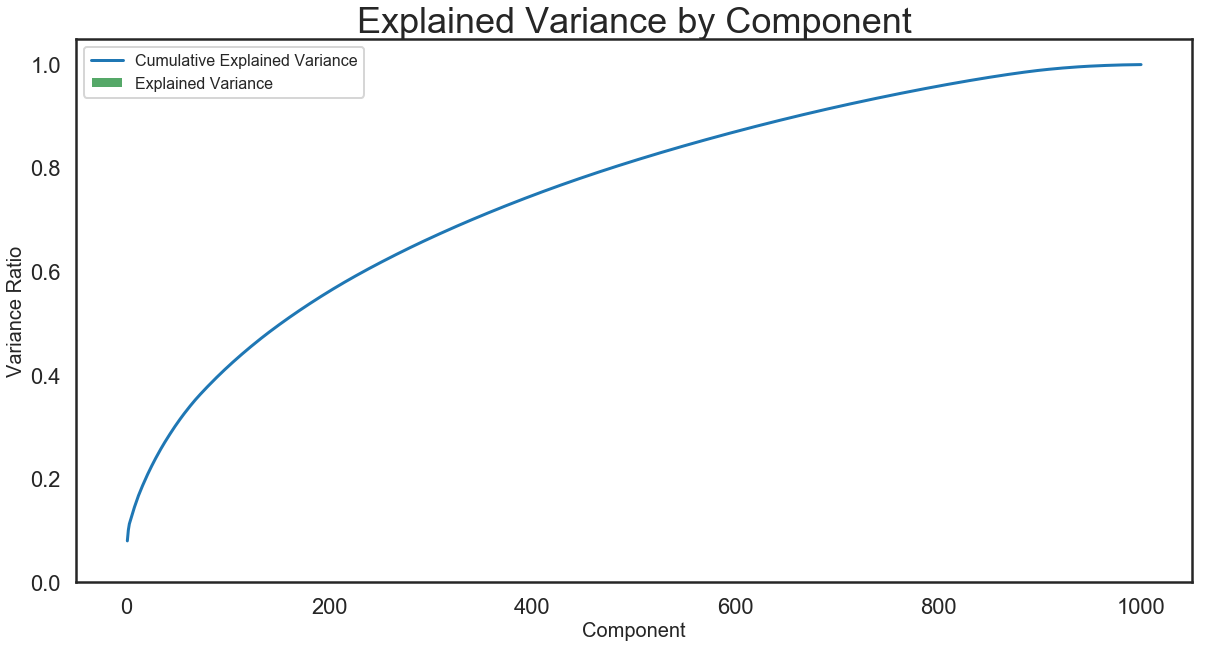

In [32]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(1000))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='Explained Variance')
plt.plot(np.array(range(1000))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='Cumulative Explained Variance')
plt.legend(fontsize=16)
plt.xlabel('Component', fontsize=20)
plt.ylabel('Variance Ratio', fontsize=20)
plt.title('Explained Variance by Component', fontsize=36);

In [33]:
np.cumsum(SVD.explained_variance_)

array([0.07277584, 0.09190323, 0.10268834, 0.10860638, 0.11485275,
       0.12080174, 0.12650296, 0.13204213, 0.13721215, 0.14242354,
       0.1474821 , 0.15243225, 0.15686774, 0.16129233, 0.16559715,
       0.16985583, 0.1739408 , 0.17800312, 0.18199848, 0.18593369,
       0.18980081, 0.19358001, 0.19734758, 0.20096185, 0.20449415,
       0.20801397, 0.21149804, 0.21492402, 0.2182592 , 0.22156527,
       0.22483169, 0.22806543, 0.231258  , 0.23440684, 0.23750351,
       0.2405346 , 0.24349856, 0.24645827, 0.24936262, 0.25220796,
       0.25504266, 0.25785496, 0.26064842, 0.26341141, 0.26614736,
       0.26884709, 0.2715332 , 0.27417421, 0.27675895, 0.27932658,
       0.28185922, 0.28437563, 0.28685701, 0.28933418, 0.29176295,
       0.29414032, 0.29649295, 0.29880987, 0.30111443, 0.3033929 ,
       0.30564876, 0.30789135, 0.3101118 , 0.31230184, 0.31448717,
       0.31661873, 0.31872395, 0.32077731, 0.32281526, 0.32483289,
       0.32681885, 0.32876121, 0.33070939, 0.33263592, 0.33454

In [34]:
component_names = ["component_"+str(i+1) for i in range(1000)]
svd_df = pd.SparseDataFrame(svd_matrix,columns=component_names)

In [35]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_991,component_992,component_993,component_994,component_995,component_996,component_997,component_998,component_999,component_1000
0,0.005016,0.014647,-0.003226,0.058611,-0.006700,0.013822,-0.008625,0.003453,0.025933,-0.000576,...,0.000040,-0.000147,-0.000286,-0.000102,-0.000493,0.000154,-0.000345,-0.000045,-0.000102,-1.260988e-03
1,0.026975,0.210709,-0.034786,0.194397,-0.054635,-0.124287,-0.146434,-0.017351,-0.051409,-0.023725,...,-0.000077,-0.000114,0.000353,0.000520,0.000272,-0.000215,-0.000659,-0.000405,-0.000872,-9.804278e-07
2,0.114781,-0.002233,0.005852,0.034468,0.000064,0.009142,-0.005992,0.003522,0.022028,-0.013263,...,-0.000904,0.002028,0.000706,0.000628,0.000545,0.000764,-0.000596,-0.001714,-0.000419,5.358980e-04
3,0.006440,0.021611,-0.006780,0.205187,-0.066172,0.220408,-0.019286,-0.000557,-0.050101,0.285196,...,-0.000455,0.000404,0.000524,-0.000016,-0.000768,0.000280,0.000565,-0.001233,-0.000134,-3.659591e-03
4,0.023091,0.186814,-0.030821,0.206578,-0.100416,0.084896,-0.203563,-0.017627,-0.140597,-0.009694,...,0.000065,0.000048,0.000820,0.000284,0.001031,-0.000021,-0.000162,-0.000428,-0.000049,-1.456368e-04


In [36]:
loadings = pd.SparseDataFrame(SVD.components_,
                              index=component_names,
                              columns=df_tfidf.columns).T

In [37]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)
loadings['abs_component_3'] = np.abs(loadings.component_3)
loadings['abs_component_4'] = np.abs(loadings.component_4)

In [38]:
loadings.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_995,component_996,component_997,component_998,component_999,component_1000,abs_component_1,abs_component_2,abs_component_3,abs_component_4
00,0.000778,0.001449,-0.000124,0.004630,-0.000716,0.001178,0.000149,0.000199,0.012501,-0.010824,...,-0.000837,-0.000173,-0.000774,0.000719,-0.000272,0.000042,0.000778,0.001449,0.000124,0.004630
000,0.001080,0.005306,-0.000519,0.005720,-0.000432,-0.001776,-0.002579,0.004127,0.004204,-0.002673,...,-0.000627,-0.000134,0.002362,0.000606,-0.004150,-0.000127,0.001080,0.005306,0.000519,0.005720
10,0.002954,0.009496,0.009391,0.016573,-0.002950,-0.001380,-0.006681,-0.000409,0.012022,-0.008319,...,0.000064,0.001081,0.001786,-0.003420,0.000509,-0.000325,0.002954,0.009496,0.009391,0.016573
100,0.001452,0.004386,0.013690,0.008116,-0.001502,-0.002334,0.006076,-0.000299,-0.000368,0.001890,...,0.000225,-0.018638,0.001597,0.000572,0.000101,0.000163,0.001452,0.004386,0.013690,0.008116
11,0.001051,0.004584,0.001693,0.006550,-0.001599,0.002068,-0.000224,-0.000224,0.007772,-0.005277,...,0.000373,-0.000138,0.001359,0.001487,-0.000102,0.000200,0.001051,0.004584,0.001693,0.006550


In [39]:
loadings.sort_values('abs_component_1',ascending=False).head(20)[['component_1']]

,component_1
url,0.992409
rt,0.103699
url url,0.034879
just,0.012125
new,0.009599
like,0.009184
amp,0.009029
wa,0.008999
love,0.008762
time,0.007926


In [40]:
loadings.sort_values('abs_component_2',ascending=False).head(20)[['component_2']]

,component_2
rt,0.969221
url,-0.112232
mitchellvii,0.043501
rt mitchellvii,0.043293
amp,0.039612
available,0.038678
just,0.038083
purchase,0.036648
free,0.036524
available purchase,0.036383


In [41]:
loadings.sort_values('abs_component_3',ascending=False).head(20)[['component_3']]

,component_3
available,0.316487
purchase,0.309632
available purchase,0.308289
free,0.305371
buy,0.297164
shipping,0.287911
shipping buy,0.280864
free shipping,0.269851
buy url,0.253548
nike,0.162117


In [42]:
loadings.sort_values('abs_component_4',ascending=False).head(20)[['component_4']]

,component_4
just,0.418255
like,0.387160
wa,0.369792
don,0.227332
know,0.217200
love,0.182656
good,0.163646
lol,0.160097
rt,-0.151910
time,0.132907


In [43]:
cos_sim_mat = cosine_similarity(svd_df, svd_df)
cos_sim_mat.shape

(21422, 21422)

In [44]:
np.argsort(cos_sim_mat[1])[:-11:-1]

array([    1, 13425,  5312,  7493, 12004,   197,   250,    13,     4,
        9495])

In [45]:
np.sort(cos_sim_mat[1])[:-11:-1]

array([1.        , 0.60565513, 0.56215852, 0.5587368 , 0.55491704,
       0.5535928 , 0.53370792, 0.53320471, 0.51540501, 0.49485011])

In [47]:
df_tfidf.loc[np.argsort(cos_sim_mat[50])[:-1], :]

,00,000,10,100,11,12,120,13,130,130 free,...,year url,yep,yes,yesterday,yo,young,youtube,youtube playlist,youtube video,zip
278,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
657,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
603,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
742,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
890,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
861,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
695,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
268,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
582,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
6921,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0


In [53]:
df.head()
print(df.shape)

(21422, 4)


In [54]:
df_tfidf.head()
print(df_tfidf.shape)

(21422, 1056)


In [27]:
pivot=pd.pivot_table(ratings_with_title, index='title', columns='userId', values='rating')

In [36]:
recommender_df = pd.DataFrame(recommender, index=pivot.index, columns=pivot.index)

In [37]:
recommender_df['Matrix, The (1999)'].sort_values()

title
Matrix, The (1999)                                                                0.000000
Fight Club (1999)                                                                 0.286063
Star Wars: Episode V - The Empire Strikes Back (1980)                             0.299065
Saving Private Ryan (1998)                                                        0.320385
Star Wars: Episode IV - A New Hope (1977)                                         0.336553
Star Wars: Episode VI - Return of the Jedi (1983)                                 0.339016
Lord of the Rings: The Fellowship of the Ring, The (2001)                         0.345872
Sixth Sense, The (1999)                                                           0.348693
Lord of the Rings: The Return of the King, The (2003)                             0.359797
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    0.368893
Gladiator (2000)                                                                  0.

## Evaluate recommender performance
---

Now comes the fun part! Let's check out a few movies to see if the recommender aligns with our intuition. In the cell below we'll do the following:
1. Create a search term
2. Use that to find all titles matching the search query
3. For each title, we'll list off the following:
  1. The average rating
  2. The number of ratings
  3. The ten most similar movies

In [53]:
search = 'Office Space'

for t in movies[movies['title'].str.contains(search)]['title']:
    print(t)
    print(f'Average Rating {ratings_with_title[ratings_with_title["title"] == t]["rating"].mean()}')
    print(f'Number of ratings {ratings_with_title[ratings_with_title["title"] == t].shape[0]}')
    print('')
    print('Recommendations')
    print(recommender_df[t].sort_values()[1:11])
    print('')
    print('***********************')
    print('')

Office Space (1999)
Average Rating 4.090425531914893
Number of ratings 94

Recommendations
title
Big Lebowski, The (1998)                              0.455962
Ferris Bueller's Day Off (1986)                       0.458094
Groundhog Day (1993)                                  0.465074
South Park: Bigger, Longer and Uncut (1999)           0.465806
Austin Powers: The Spy Who Shagged Me (1999)          0.469728
Monty Python and the Holy Grail (1975)                0.471704
Dogma (1999)                                          0.472235
Austin Powers: International Man of Mystery (1997)    0.472711
Reservoir Dogs (1992)                                 0.486166
American Beauty (1999)                                0.490346
Name: Office Space (1999), dtype: float64

***********************



### HDBSCAN

In [99]:
plt.figure(figsize=(20,10));
# plt.scatter(df_tfidf.T[0], df_tfidf.T[1])

<Figure size 1440x720 with 0 Axes>

In [68]:
cluster = hdbscan.HDBSCAN(min_cluster_size = 15, gen_min_span_tree = True)
cluster.fit(svd_df)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=15, min_samples=None, p=None,
    prediction_data=False)

In [69]:
cluster.labels_

array([-1, -1, -1, ..., 58, -1, -1])

In [70]:
plt.figure(figsize=(20,10))
cluster.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                    edge_alpha=0.6,
                                    node_size=80,
                                    edge_linewidth=2)

AttributeError: No minimum spanning tree was generated.This may be due to optimized algorithm variations that skip explicit generation of the spanning tree.

<Figure size 1440x720 with 0 Axes>

## We can also visually represent the clustering hierarchy

In [ ]:
plt.figure(figsize=(20,10))
cluster.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

## If we condense this plot, we can get a better idea of our final clusters

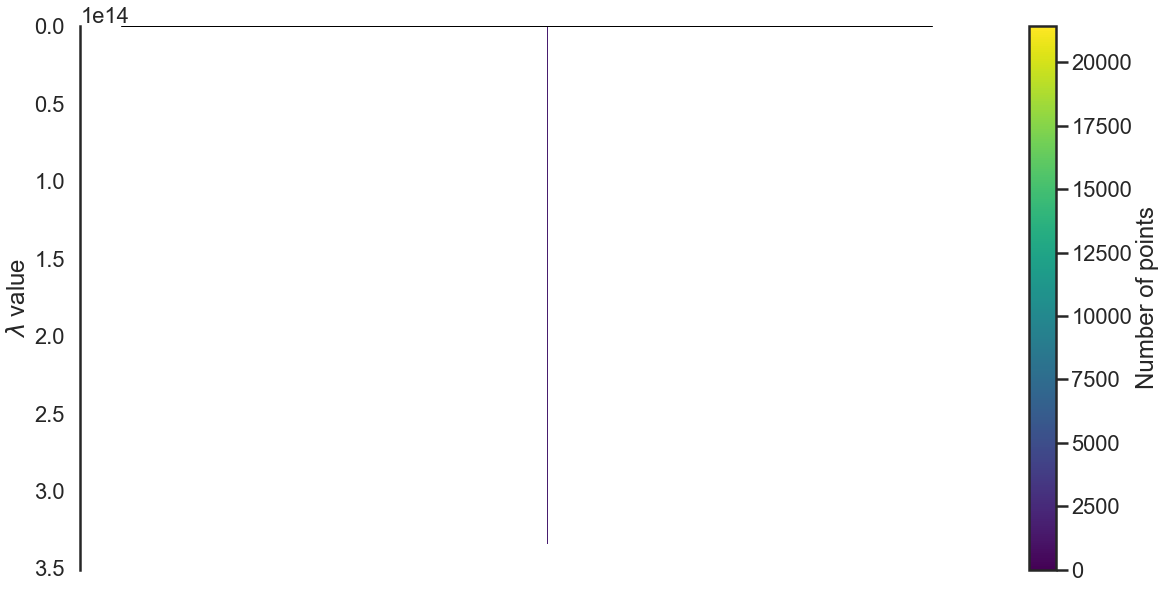

In [72]:
plt.figure(figsize=(20,10))
cluster.condensed_tree_.plot()

## And then we can actually visually represent which clusters are selected

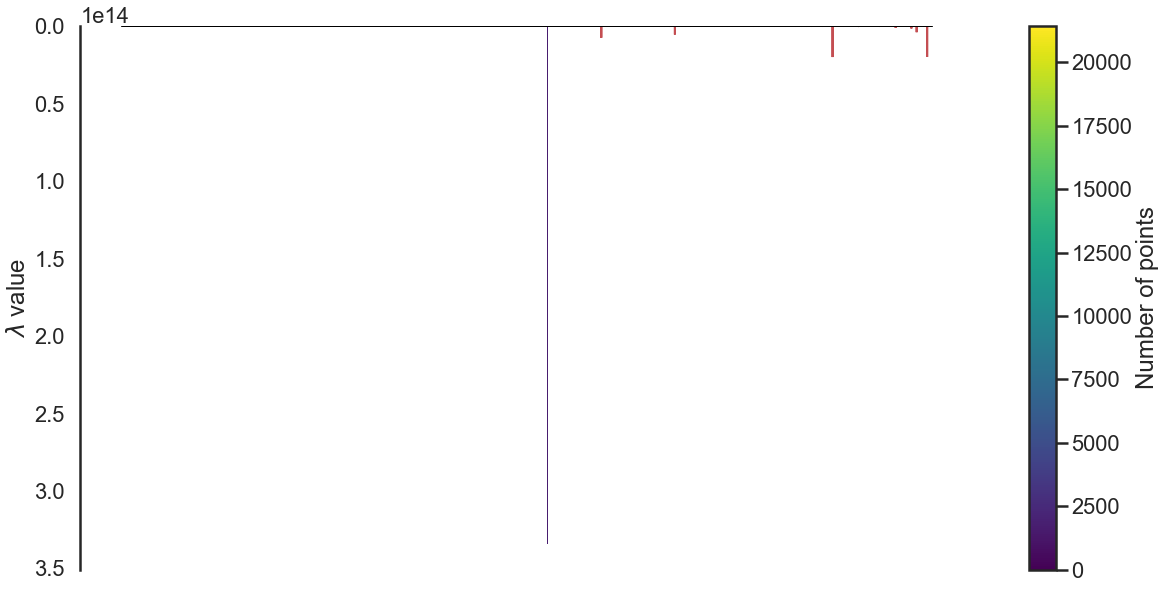

In [73]:
plt.figure(figsize=(20,10))
cluster.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

## Let's look at these clusters back in our original scatterplot

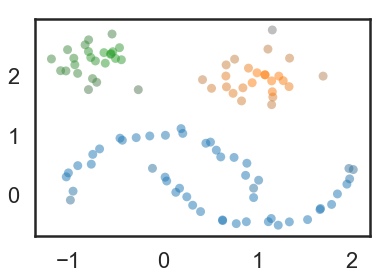

In [9]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

### Using spaCy

In [23]:
nlp = spacy.load('en_core_web_md')

In [24]:
#Function to clean up text
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print(f"Processed {counter} out of {len(docs)} documents.")
        doc = nlp(doc, disable=['parser', 'ner']) #disabling default models of spacy
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']  #Applyint tokenizing and lemmatizing
        tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS and tok not in string.punctuation] #Removing stopwords and punctuations
        tokens = ' '.join(tokens) 
        texts.append(tokens)  #Appending clean titles to texts list
    return pd.Series(texts)   #Returning texts list as pd Series

In [25]:
cleanup_text(df)

0    text
dtype: object

In [3]:
tweets_clean = cleanup_text(lemm_clean_processed_list)
tweets_clean = ' '.join(lemm_clean_processed_list).split()

tweets_counts = Counter(tweets_clean)

tweets_common_words = [word[0] for word in tweets_counts.most_common(20)]
tweets_common_counts = [word[1] for word in tweets_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=tweets_common_words, y=tweets_common_counts, palette = "GnBu_d")
sns.set(font_scale=1.5, rc={'figure.figsize':(8, 8)})
plt.title('Most Common Words used in tweets')
plt.show()

ModuleNotFoundError: No module named 'spacy'